<a href="https://colab.research.google.com/github/ogunjosam/ISIMIP_data/blob/main/ISIMIP_onset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is designed to download and process heavy atmospheric data in the cloud.  

It will be used in two (for now) papers by the OOO consortium:
1.  Onset
2.  Widespread precipitation

### Install and import necessary packages here 

In [ ]:
!pip install xarray[complete]


import glob
import matplotlib.pyplot as plt
import urllib.request
import xarray as xr
import pandas as pd
import numpy as np
import seaborn as sns


!mkdir Data  # create a directory to store processed data

     |████████████████████████████████| 136 kB 5.0 MB/s 
     |████████████████████████████████| 19.3 MB 11.1 MB/s 
     |████████████████████████████████| 153 kB 48.5 MB/s 
     |████████████████████████████████| 2.3 MB 31.4 MB/s 
     |████████████████████████████████| 45 kB 3.1 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 837 kB 41.5 MB/s 
     |████████████████████████████████| 830 kB 43.0 MB/s 
     |████████████████████████████████| 822 kB 35.9 MB/s 
     |████████████████████████████████| 802 kB 43.3 MB/s 
     |████████████████████████████████| 802 kB 38.2 MB/s 
     |████████████████████████████████| 793 kB 41.4 MB/s 
     |████████████████████████████████| 793 kB 44.7 MB/s 
     |████████████████████████████████| 791 kB 40.8 MB/s 
     |████████████████████████████████| 786 kB 34.6 MB/s 
     |████████████████████████████████| 779 kB 22.5 MB/s 
     |████████████████████████████████| 778 kB 40.7 MB/s 
     |████████████

/usr/local/lib/python3.7/dist-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


This function has a good purpose

In [ ]:
def index_locator(data,cord):
    cor_lat = data
    latbounds = cord
    cor_lat = pd.DataFrame(cor_lat)
    print([latbounds])
    cor_lat2 = pd.DataFrame({'a':cor_lat.iloc[:,0], 'b':abs(cor_lat.iloc[:,0] - latbounds)})
    a = cor_lat2[cor_lat2.b == min(cor_lat2.b)].first_valid_index()
    
    return a

Can we download all the data in a loop?

In [ ]:
for yr in range(1901,2000,10):

  url  = f'http://esg.pik-potsdam.de/thredds/fileServer/isimip_dataroot/isimip2a/input/clim_atm_obs/GSWP3/historical/pr/daily/v20180927/pr_gswp3_{yr}_{yr+9}.nc'
  print(url)

  savename = url.split('/')[-1]

  urllib.request.urlretrieve(url, savename)

  data = xr.open_dataset(savename)

  ds_sel = data.isel(lon=(data.lon >= -18) & (data.lon <= 20),
                lat=(data.lat >= 0) & (data.lat <= 15),
                )
  ds_sel.to_netcdf(path="./Data/"+savename)


http://esg.pik-potsdam.de/thredds/fileServer/isimip_dataroot/isimip2a/input/clim_atm_obs/GSWP3/historical/pr/daily/v20180927/pr_gswp3_1901_1910.nc
http://esg.pik-potsdam.de/thredds/fileServer/isimip_dataroot/isimip2a/input/clim_atm_obs/GSWP3/historical/pr/daily/v20180927/pr_gswp3_1911_1920.nc
http://esg.pik-potsdam.de/thredds/fileServer/isimip_dataroot/isimip2a/input/clim_atm_obs/GSWP3/historical/pr/daily/v20180927/pr_gswp3_1921_1930.nc
http://esg.pik-potsdam.de/thredds/fileServer/isimip_dataroot/isimip2a/input/clim_atm_obs/GSWP3/historical/pr/daily/v20180927/pr_gswp3_1931_1940.nc
http://esg.pik-potsdam.de/thredds/fileServer/isimip_dataroot/isimip2a/input/clim_atm_obs/GSWP3/historical/pr/daily/v20180927/pr_gswp3_1941_1950.nc
http://esg.pik-potsdam.de/thredds/fileServer/isimip_dataroot/isimip2a/input/clim_atm_obs/GSWP3/historical/pr/daily/v20180927/pr_gswp3_1951_1960.nc
http://esg.pik-potsdam.de/thredds/fileServer/isimip_dataroot/isimip2a/input/clim_atm_obs/GSWP3/historical/pr/daily/v20

The functions for estimating onset using Liebmann method

In [ ]:
def dailyClim(x):

    daily_clim = np.copy(x)
    daily_clim.shape = (int(len(x) / 365), 365)
    daily_clim = np.apply_along_axis(np.mean, 0, daily_clim)

    return daily_clim

def getDate(x, i_wet_i, f_wet_i, wInd, R_ave):

    i_wet = int(np.where(i_wet_i - wInd < 0, 0, i_wet_i - wInd))
    f_wet = int(np.where(f_wet_i + wInd > 365, 365, f_wet_i + wInd))
    d_year = np.cumsum(x[i_wet:f_wet] - R_ave)
    if d_year.size > 0:
      onset_year = np.argmin(d_year)
      
      cessation_year = np.argmax(d_year)
    else:
      onset_year = 0
      cessation_year = 0


    return [onset_year, cessation_year]

def getOnsetCessation(x, wInd=5):

    ## daily climatology
    daily_clim = dailyClim(x)

    ## climatology onset and cessation dates
    R_ave = np.mean(daily_clim)
    d = np.cumsum(daily_clim - R_ave)
    
    i_wet_clim = np.argmin(d)
    f_wet_clim = np.argmax(d)

    ## getting onset and cessation dates by hydrological year
    wet_periods = np.split(x, len(x)/365)
    wet_periods = list(map(lambda y: getDate(y, i_wet_i=i_wet_clim,
                                             f_wet_i=f_wet_clim,
                                             wInd=wInd,
                                             R_ave=R_ave),
                           wet_periods))

    return np.concatenate(wet_periods, axis=0) + np.repeat(np.arange(0, len(x), 365), 2)


def lengthOC_func(z):
    map_in_x = z[np.arange(0, len(z), 2)]
    map_in_y = z[np.arange(1, len(z), 2)]
    # some years can not be computed because:
    # 1) data is bad
    # 2) the year does not follow the seasonality
    # 3) an atypical year
    lengthOC = [np.where(y - x < 0, np.nan, y - x) for x, y in zip(map_in_x, map_in_y)]

    return np.array(lengthOC)

def onset_func(z):
    map_in_x = z[np.arange(0, len(z), 2)]
    map_in_y = z[np.arange(1, len(z), 2)]
    

    return map_in_y

Time to combine all the data into one big, very huge, file

In [ ]:
afr_data = xr.open_mfdataset('Data/*.nc', concat_dim='time', combine='nested').load()

#afr_data.pr = afr_data.pr * 86400

#afr_data = afr_data.sel(time=slice("1981-08-01", "2016-07-31"))
afr_data = afr_data.isel(time=~afr_data.time.dt.strftime('%m-%d').isin("02-29"))

OC_gridded = xr.apply_ufunc(getOnsetCessation,
                            afr_data.pr*86400,
                            input_core_dims=[['time']],
                            output_core_dims=[["z"]],
                            dask='parallelized',
                            vectorize=True,
                            output_dtypes=['float64'])

OC_gridded

<xarray.DataArray 'pr' (lat: 30, lon: 76, z: 200)>
array([[[1.6000e+01, 9.4000e+01, 3.7400e+02, ..., 3.5872e+04,
         3.6151e+04, 3.6237e+04],
        [2.2000e+01, 9.0000e+01, 3.8000e+02, ..., 3.5872e+04,
         3.6157e+04, 3.6228e+04],
        [5.0000e+00, 9.1000e+01, 3.8000e+02, ..., 3.5877e+04,
         3.6157e+04, 3.6242e+04],
        ...,
        [2.1000e+01, 8.9000e+01, 3.9400e+02, ..., 3.5853e+04,
         3.6165e+04, 3.6207e+04],
        [0.0000e+00, 8.1000e+01, 3.8300e+02, ..., 3.5853e+04,
         3.6165e+04, 3.6207e+04],
        [1.0000e+00, 8.5000e+01, 3.8700e+02, ..., 3.5857e+04,
         3.6170e+04, 3.6214e+04]],

       [[2.1000e+01, 9.9000e+01, 3.7900e+02, ..., 3.5877e+04,
         3.6153e+04, 3.6242e+04],
        [2.1000e+01, 9.0000e+01, 3.7900e+02, ..., 3.5869e+04,
         3.6156e+04, 3.6241e+04],
        [2.2000e+01, 9.8000e+01, 3.8600e+02, ..., 3.5869e+04,
         3.6157e+04, 3.6227e+04],
...
        [1.2000e+02, 3.6000e+01, 3.7000e+02, ..., 3.5884e+04,
         3.6140e+04, 3.6245e+04],
        [1.1800e+02, 3.9000e+01, 3.7300e+02, ..., 3.5888e+04,
         3.6143e+04, 3.6248e+04],
        [1.2000e+02, 3.8000e+01, 3.6900e+02, ..., 3.5890e+04,
         3.6141e+04, 3.6246e+04]],

       [[0.0000e+00, 0.0000e+00, 3.6500e+02, ..., 3.5770e+04,
         3.6135e+04, 3.6135e+04],
        [0.0000e+00, 0.0000e+00, 3.6500e+02, ..., 3.5770e+04,
         3.6135e+04, 3.6135e+04],
        [0.0000e+00, 0.0000e+00, 3.6500e+02, ..., 3.5770e+04,
         3.6135e+04, 3.6135e+04],
        ...,
        [7.2000e+01, 2.9000e+01, 3.7000e+02, ..., 3.5892e+04,
         3.6149e+04, 3.6245e+04],
        [7.8000e+01, 3.0000e+01, 3.7100e+02, ..., 3.5890e+04,
         3.6141e+04, 3.6250e+04],
        [7.8000e+01, 3.7000e+01, 3.7100e+02, ..., 3.5887e+04,
         3.6141e+04, 3.6250e+04]]])
Coordinates:
  * lon      (lon) float64 -17.75 -17.25 -16.75 -16.25 ... 18.75 19.25 19.75
  * lat      (lat) float64 14.75 14.25 13.75 13.25 12.75 ... 1.75 1.25 0.75 0.25
Dimensions without coordinates: z

Dummy space

<xarray.DataArray 'pr' (lat: 30, lon: 76, z3: 100)>
array([[[ 78.,  40.,  80., ...,  70.,  69.,  86.],
        [ 68.,  74.,  55., ...,  59.,  85.,  71.],
        [ 86.,  74.,  68., ...,  71.,  90.,  85.],
        ...,
        [ 68.,  55.,  30., ...,  81.,  66.,  42.],
        [ 81.,  66.,  22., ...,  86.,  66.,  42.],
        [ 84.,  67.,  22., ...,  87.,  65.,  44.]],

       [[ 78.,  44.,  72., ...,  75.,  75.,  89.],
        [ 69.,  74.,  49., ...,  66.,  81.,  85.],
        [ 76.,  68.,  57., ...,  75.,  87.,  70.],
        ...,
        [ 98.,  81.,  30., ...,  74.,  66.,  44.],
        [ 81.,  81.,  28., ...,  83.,  68.,  45.],
        [ 52.,  76.,  29., ...,  86.,  70.,  44.]],

       [[ 77.,  38.,  81., ...,  76.,  78.,  90.],
        [ 77.,  38.,  94., ...,  76.,  78.,  90.],
        [105.,  68.,  46., ...,  68.,  74.,  74.],
        ...,
...
        ...,
        [190.,  78., 199., ...,  90., 248., 141.],
        [186.,  78., 199., ..., 105., 257., 163.],
        [ nan,  80.,  75., ..., 105., 113., 105.]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [ nan,  79.,  74., ..., 106., 111., 105.],
        [ nan,  78.,  75., ..., 105., 118., 105.],
        [ nan,  80.,  75., ..., 105., 117., 105.]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [ nan, 112.,  76., ..., 116.,  87.,  96.],
        [ nan, 112.,  76., ..., 105.,  80., 109.],
        [ nan, 112.,  75., ..., 106.,  77., 109.]]])
Coordinates:
  * lon      (lon) float64 -17.75 -17.25 -16.75 -16.25 ... 18.75 19.25 19.75
  * lat      (lat) float64 14.75 14.25 13.75 13.25 12.75 ... 1.75 1.25 0.75 0.25
Dimensions without coordinates: z3

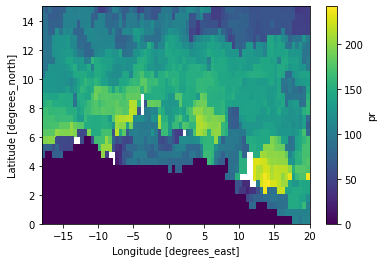

In [ ]:
lengthOC_gridded = xr.apply_ufunc(lengthOC_func,
                                  OC_gridded,
                                  vectorize = True,
                                  input_core_dims=[["z"]],
                                  output_core_dims=[["z3"]],
                                  output_dtypes=['float64'])

# spatial variability of the lengthOC in the year 1
lengthOC_gridded.isel(z3=99).plot()

lengthOC_gridded

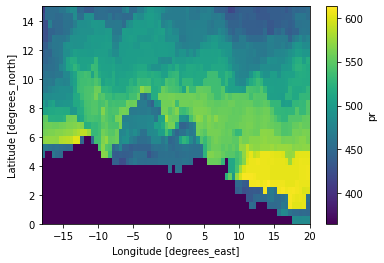

In [ ]:
onset_gridded = xr.apply_ufunc(onset_func,
                            OC_gridded,
                            input_core_dims=[['z']],
                            output_core_dims=[["z3"]],
                            dask='parallelized',
                            vectorize=True,
                            output_dtypes=['float64'])
 

onset_gridded.isel(z3=1).plot()

In [ ]:
afr_data.pr[1,:,:]

<xarray.DataArray 'pr' (lat: 30, lon: 76)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.81186635e-06, 8.44679198e-06, 1.37115621e-05, ...,
        4.58317709e-06, 4.30533555e-06, 7.98485871e-06],
       [5.86531205e-05, 5.86234091e-05, 4.37863127e-05, ...,
        5.08888188e-05, 3.46035558e-05, 5.22211049e-05],
       [1.09046734e-04, 6.28271373e-05, 1.77229504e-05, ...,
        6.31866351e-05, 1.08032233e-04, 1.09818677e-04]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -17.75 -17.25 -16.75 -16.25 ... 18.75 19.25 19.75
  * lat      (lat) float64 14.75 14.25 13.75 13.25 12.75 ... 1.75 1.25 0.75 0.25
    time     datetime64[ns] 1901-01-02
Attributes:
    units:          kg m-2 s-1
    standard_name:  precipitation_flux
    long_name:      Precipitation